# Neural Network

In [ ]:
# Import necessary packages
# If running block of code on google Colab, uncomment the line below
#!sudo -H pip install seaborn==0.9.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pandas.api.types import CategoricalDtype
import calendar
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [ ]:
# Read in dates as datetime objects and create a dictionary 'd_dtypes' to read in other data types correctly
dates = ['applicationDate','approvalDate','disbursementDate','dueDate','repaidDate',
         'FirstPaymentDueDate']
d_types = {'loanId':str,
           'clientId': str,
           'clientIncome': float,
           'incomeVerified':object,
          'clientGender':'category',
          'clientMaritalStatus':'category',
          'clientLoanPurpose':'category',
          'clientResidentialStauts':'category',
          'clientState':'category',
            'clientTimeAtEmployer':'category',
          'clientNumberPhoneContacts':float,
           'clientAvgCallsPerDay':float,
           'loanTerm': 'category',
           'settleDays':int,
           'firstPaymentRatio':float}

In [ ]:
# Read in the raw dataset gotten from bigquery and pass the necessary arguments
# change the filepath to where your csv file is located
loans = pd.read_csv('Downloads/loans-query.csv', parse_dates= dates, na_values=['Null','nan'], infer_datetime_format=True, 
                    dtype=d_types)

/Users/mercy/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Convert loanTerm to a categorical data type and make it ordered
cat_type_loan = CategoricalDtype(categories=['60', '90', '180'],ordered=True)
loans['loanTerm'] = loans['loanTerm'].astype(cat_type_loan)

In [ ]:
# Inspect loans information
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159596 entries, 0 to 159595
Data columns (total 33 columns):
loanId                       159596 non-null object
clientId                     159596 non-null object
clientIncome                 159596 non-null float64
incomeVerified               159493 non-null object
clientAge                    159596 non-null int64
clientGender                 159596 non-null category
clientMaritalStatus          159590 non-null category
clientLoanPurpose            159596 non-null category
clientResidentialStauts      158460 non-null category
clientState                  159595 non-null category
clientTimeAtEmployer         155402 non-null category
clientNumberPhoneContacts    156888 non-null float64
clientAvgCallsPerDay         156909 non-null float64
loanType                     159596 non-null object
loanNumber                   159596 non-null int64
applicationDate              159596 non-null datetime64[ns]
approvalDate                 159596 

In [ ]:
# Check the number of unique values across all the columns
loans.nunique().to_frame().transpose()

,loanId,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanType,loanNumber,applicationDate,approvalDate,declinedDate,disbursementDate,payout_status,dueDate,paidAt,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,repaidDate,settleDays,firstPaymentRatio,FirstPaymentDueDate,firstPaymentDefault,loanDefault
0,159596,91904,9362,2,44,2,5,5,5,39,40,7377,100306,1,32,316,316,5,305,1,157900,125481,483,133,3,2,2,138120,419,4875,299,2,2


In [ ]:
# Sum of missing values in the dataset
loans.isna().sum()

loanId                            0
clientId                          0
clientIncome                      0
incomeVerified                  103
clientAge                         0
clientGender                      0
clientMaritalStatus               6
clientLoanPurpose                 0
clientResidentialStauts        1136
clientState                       1
clientTimeAtEmployer           4194
clientNumberPhoneContacts      2708
clientAvgCallsPerDay           2687
loanType                          0
loanNumber                        0
applicationDate                   0
approvalDate                      0
declinedDate                 159589
disbursementDate                  0
payout_status                     0
dueDate                           0
paidAt                        29800
loanAmount                        0
interestRate                      0
loanTerm                          0
max_amount_taken                  0
max_tenor_taken                   0
repaidDate                  

In [ ]:
loans.describe()
# An anomaly was noticed in the clientAge column; maximum age is 138. Look into this.

,clientIncome,clientAge,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,max_amount_taken,max_tenor_taken,settleDays,firstPaymentRatio,firstPaymentDefault,loanDefault
count,1.595960e+05,159596.000000,156888.000000,156909.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000
mean,9.083906e+04,33.691847,1262.284936,59.137352,3.556806,35324.184190,13.331235,0.705275,0.915374,32.602189,0.097991,0.294268,0.277526
std,9.728033e+04,7.180870,1525.329265,102.064134,2.471578,27840.824297,4.467938,0.455921,0.278325,84.552544,0.278058,0.455714,0.447779
min,3.000000e+01,18.000000,0.000000,0.000000,1.000000,11000.000000,4.500000,0.000000,0.000000,-32.000000,0.000000,0.000000,0.000000
25%,3.500000e+04,28.000000,429.000000,9.885246,2.000000,20000.000000,10.000000,0.000000,1.000000,-2.000000,0.000000,0.000000,0.000000
50%,5.511621e+04,33.000000,825.000000,29.383838,3.000000,25500.000000,12.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.050000e+05,38.000000,1550.000000,70.046763,4.000000,37500.000000,15.000000,1.000000,1.000000,13.000000,0.000000,1.000000,1.000000
max,3.925000e+06,138.000000,60595.000000,10994.500000,32.000000,500000.000000,20.000000,1.000000,1.000000,386.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

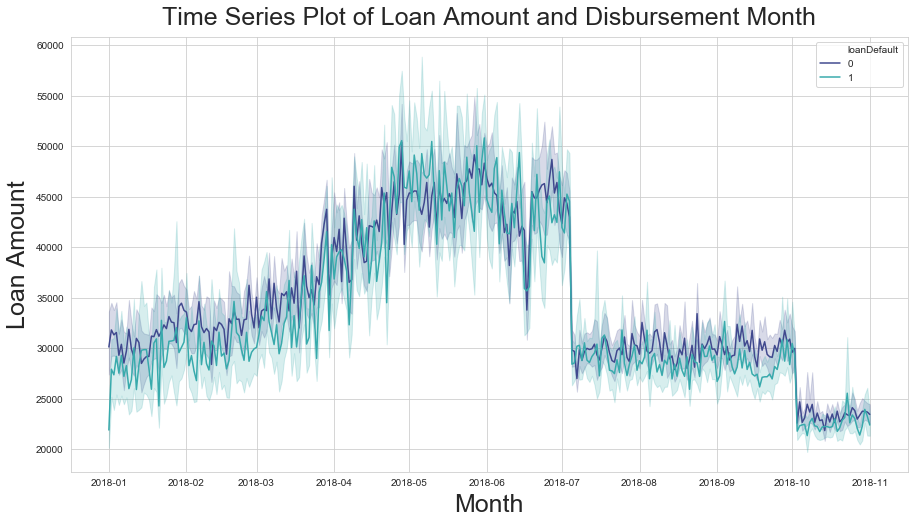

In [ ]:
# Plot a timeseries line plot showing the status of loan amounts as a function of the disbursement date's month
plt.figure(figsize=(15,8))

sns.lineplot(x='disbursementDate', y='loanAmount',hue='loanDefault', data=loans, palette='mako')

plt.xlabel('Month', fontsize=25, labelpad=6)
plt.ylabel('Loan Amount', fontsize=25, labelpad=6)
plt.title('Time Series Plot of Loan Amount and Disbursement Month', fontsize=25, pad=12);

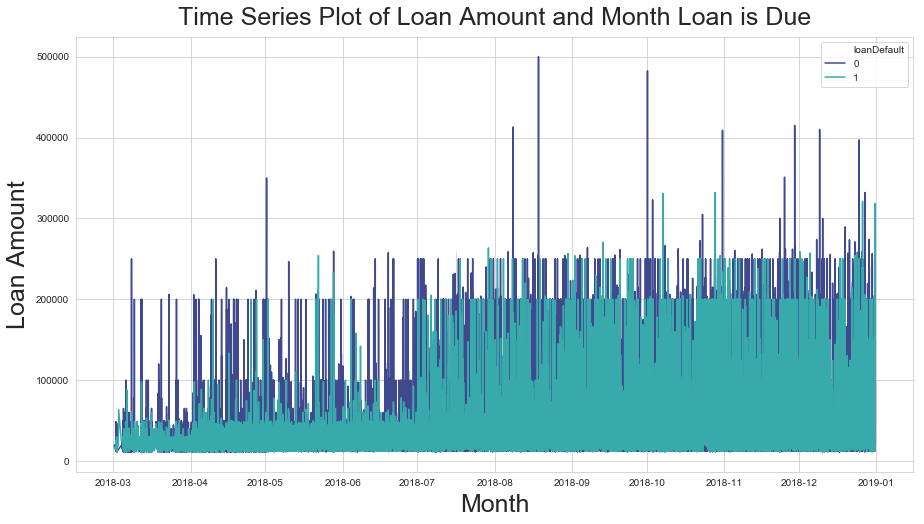

In [ ]:
plt.figure(figsize=(15,8))
# Plot a timeseries line plot showing the status of loan amounts as a function of the due date's month
sns.lineplot(x='dueDate', y='loanAmount',hue='loanDefault', data=loans, palette='mako')

plt.xlabel('Month', fontsize=25, labelpad=6)
plt.ylabel('Loan Amount', fontsize=25, labelpad=6)
plt.title('Time Series Plot of Loan Amount and Month Loan is Due', fontsize=25, pad=12);

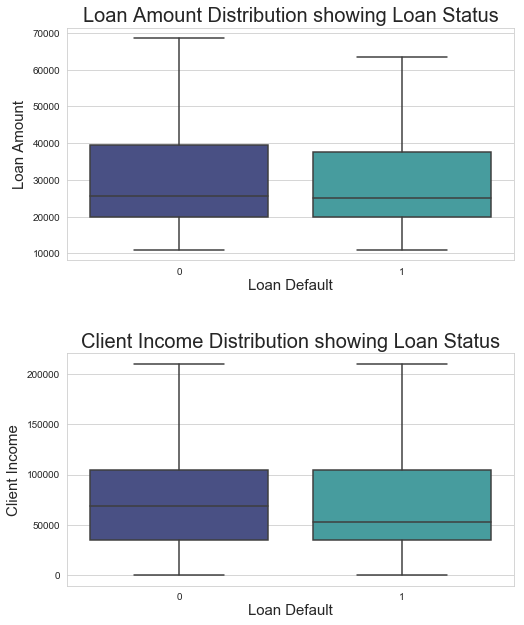

In [ ]:
# Plot a box plot showing the distribution of loans collected and their status
plt.figure(figsize=(8,10))
plt.subplot(211)
sns.boxplot(x='loanDefault', y='loanAmount', data=loans,palette='mako',showfliers=False)

plt.xlabel('Loan Default', fontsize=15, labelpad=2)
plt.ylabel('Loan Amount', fontsize=15, labelpad=6)
plt.title('Loan Amount Distribution showing Loan Status', fontsize=20, pad=6);

plt.subplot(212)

# Plot a box plot showing the distribution of client income the status of loans collected
sns.boxplot(x='loanDefault', y='clientIncome', data=loans, palette='mako', showfliers=False)

plt.xlabel('Loan Default', fontsize=15, labelpad=2)
plt.ylabel('Client Income', fontsize=15, labelpad=6)
plt.title('Client Income Distribution showing Loan Status', fontsize=20, pad=6);

plt.subplots_adjust(wspace=0.2, hspace=0.4, top=0.9)

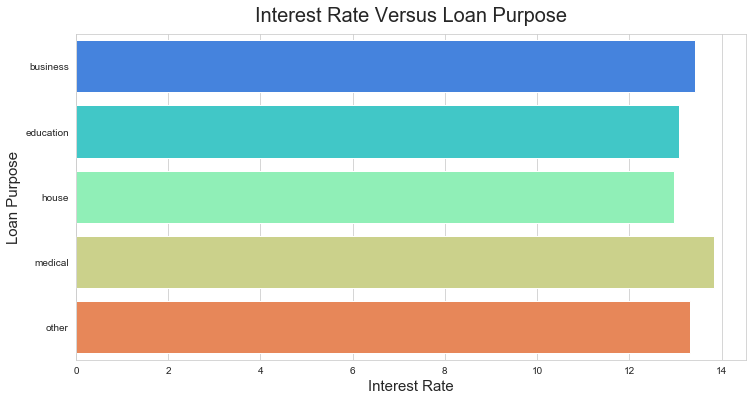

In [ ]:
# On an average, interest rates are highest for clients seeking loans for medical reasons, 
# followed by business and other reasons
plt.figure(figsize=(12,6))

data = loans.groupby('clientLoanPurpose')['interestRate'].mean()

sns.barplot(x=data.values, y=data.index, palette='rainbow')

plt.xlabel('Interest Rate', fontsize=15)
plt.ylabel('Loan Purpose', fontsize=15)
plt.title('Interest Rate Versus Loan Purpose', fontsize=20, pad=12);

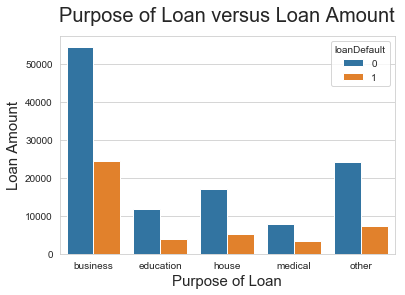

In [ ]:
# What do most client's take loans for? What reason has the most defaults?
sns.countplot(x='clientLoanPurpose', data=loans, hue='loanDefault')

plt.xlabel('Purpose of Loan', fontsize=15)
plt.ylabel('Loan Amount', fontsize=15)
plt.title('Purpose of Loan versus Loan Amount', fontsize=20, pad=15);

# Data Pre-Processing
1. Fix wrongly inputed data
2. Handle Missing Values
3. Drop columns
4. One-hot encode categorical columns
5. Build, Train and Evaluate Neural Network

### 1.1 Fix wrongly inputed data in `clientState` column

In [ ]:
# Replace wrongly entered states
loans['clientState'] = loans['clientState'].str.replace('LAGOS ', 'LAGOS')
loans['clientState'] = loans['clientState'].str.replace('OJO', 'OYO')

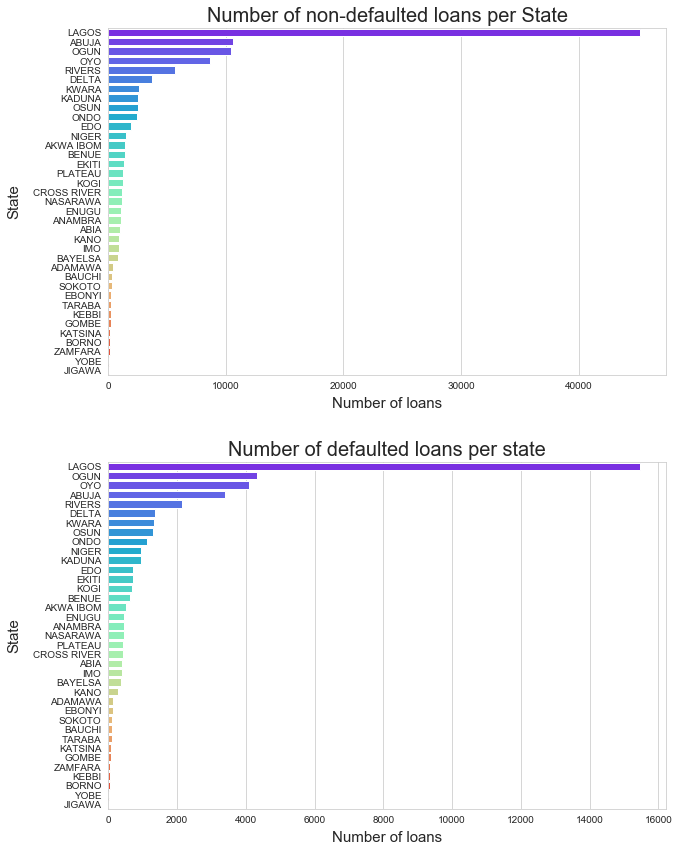

In [ ]:
# Plot a barplot of the counts of Non-defaulted loans grouped according to states
plt.figure(figsize=(10,14))
plt.subplot(211)
data = loans[loans['loanDefault']==0].groupby('clientState')['loanDefault'].count().sort_values(ascending=False)

sns.barplot(x=data.values, y=data.index, palette='rainbow')

plt.xlabel('Number of loans',fontsize=15, labelpad=6)
plt.ylabel('State',fontsize=15, labelpad=12)
plt.title('Number of non-defaulted loans per State',fontsize=20, pad=6);

plt.subplot(212)

# Plot a barplot of the counts of Defaulted loans grouped according to states
data = loans[loans['loanDefault']==1].groupby('clientState')['loanDefault'].count().sort_values(ascending=False)

sns.barplot(x=data.values, y=data.index, palette='rainbow')

plt.xlabel('Number of loans',fontsize=15, labelpad=6)
plt.ylabel('State',fontsize=15, labelpad=12)
plt.title('Number of defaulted loans per state',fontsize=20, pad=6);

plt.subplots_adjust(wspace=0.2, hspace=0.25, top=0.9)

### 1.2 Fix wrongly inputed data in `clientAge` column
Upon observation `loans.clientAge.max()` returns `138`. This was most likely an error and the client meant to input `38`

In [ ]:
# Check maximum age
loans.clientAge.max()

138

In [ ]:
# Reassign the value at the index where this error occurs
loans.loc[1165, 'clientAge'] = 38

### 2.1 Handle missing values in the `incomeVerified column`
- **`Fill Nans with 'False'`**
- **Logic behind it**: missing values are filled in with **`false`**; missing is being translated as **`unverified`**

In [ ]:
# Check value counts before filling with 'false'
loans.incomeVerified.value_counts()

false    133286
true      26207
Name: incomeVerified, dtype: int64

In [ ]:
# Replace nans in Income verified with False
loans['incomeVerified'] = loans['incomeVerified'].fillna('false')

In [ ]:
# This converts incomeVerified to a boolean data type
loans['incomeVerified'] = loans['incomeVerified'] == 'true'

In [ ]:
# Check value counts after filling and converting to boolean
loans.incomeVerified.value_counts()

False    133389
True      26207
Name: incomeVerified, dtype: int64

In [ ]:
# Remap IncomeVerified with 1:True and 0:False
loans['incomeVerified']=loans['incomeVerified'].map({True:1,False:0})

In [ ]:
# Check value counts after remapping
loans.incomeVerified.value_counts()

0    133389
1     26207
Name: incomeVerified, dtype: int64

### 2.2 Handle missing values for `clientMaritalStatus` column
- **`Fill Nans with 'Single'`**
- **Logic behind it**: Upon looking at the data, 6 missing values were encountered **`{24 : F , 26 : M , 29 : F , 33 : M , 34 : F , 36 : M}`**. This dictionary represents the ages and genders of the clients.
- Looking at the values, there's a high likehood of them being Single.

In [ ]:
# Fill missing values in with 'Single'
loans['clientMaritalStatus'] = loans['clientMaritalStatus'].fillna('Single')

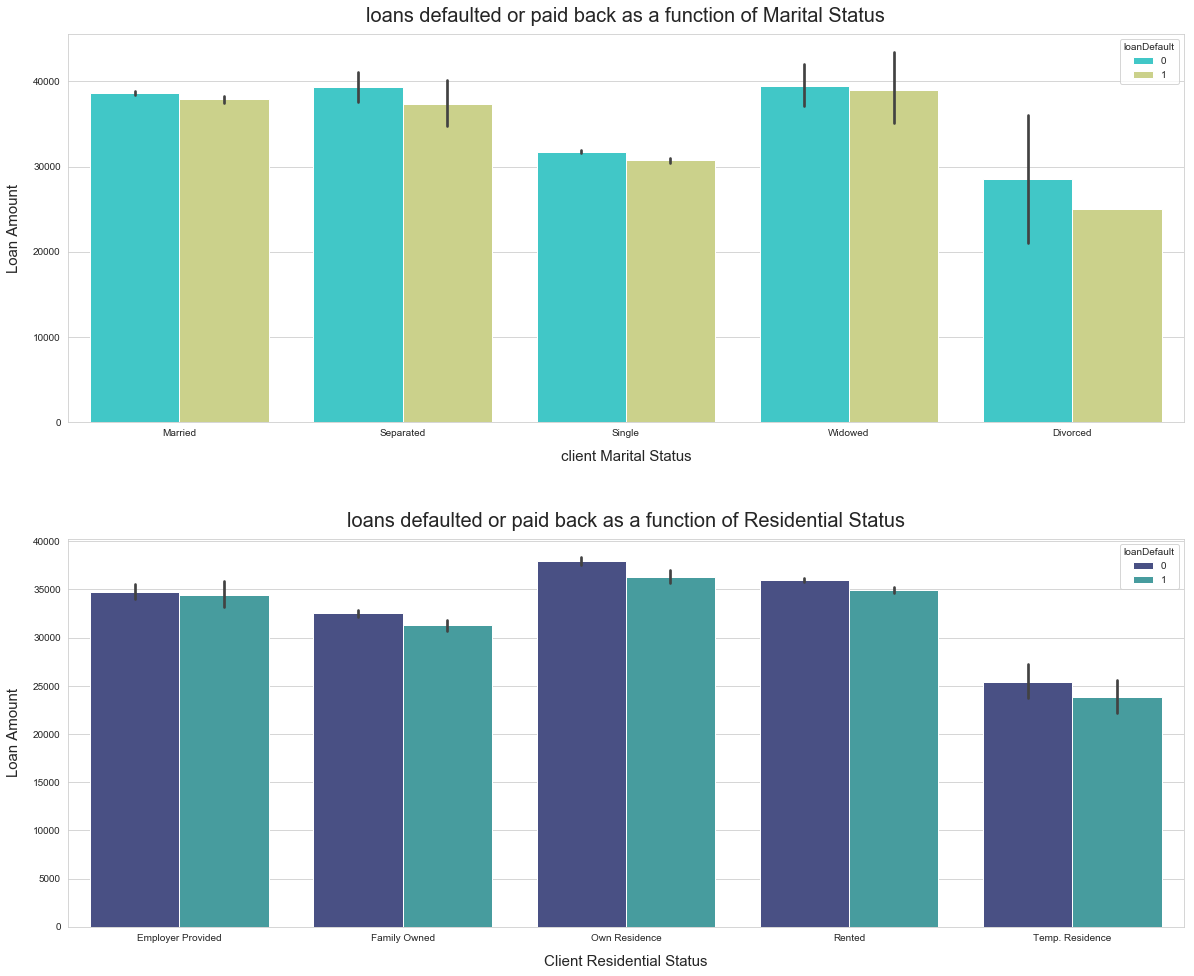

In [ ]:
# Plot a barplot of mean loan amounts defaulted on or paid back for different marital status
plt.figure(figsize=(20,16))

plt.subplot(2,1,1)
sns.barplot(x='clientMaritalStatus', y='loanAmount', hue='loanDefault', data=loans, palette='rainbow');

plt.xlabel('client Marital Status',fontsize=15, labelpad=12)
plt.ylabel('Loan Amount',fontsize=15, labelpad=12)
plt.title('loans defaulted or paid back as a function of Marital Status',fontsize=20, pad=12);

# Plot a barplot of mean loan amounts defaulted on or paid back for different residential status
plt.subplot(2,1,2)
sns.barplot(x='clientResidentialStauts', y='loanAmount', hue='loanDefault', data=loans, palette='mako');

plt.xlabel('Client Residential Status',fontsize=15, labelpad=12)
plt.ylabel('Loan Amount',fontsize=15, labelpad=12)
plt.title('loans defaulted or paid back as a function of Residential Status',fontsize=20, pad=12);

plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.9)

### 2.3 Handle missing values in the `clientTimeAtEmployer` column
- **`Fill Nans with 0`**
- **Logic behind it**: Out of **`4,194`** clients that have Nans indicated in their **`clientTimeAtEmployer`** field, only **`5.41%`** of them have Verified Income sources compared to the overall **`16.42%`** in the entire dataset and **`16.71%`** for the remaining **`155,402`** clients who provided info for the **`clientTimeAtEmployer`** field.
- This could indicate that they are unemployed and as such, filling **`clientTimeAtEmployer`** with **`0`** makes sense.

In [ ]:
# Isolate incomeVerified and clientTimeAtEmployer columns and make observations
loans_income_employer = loans[['incomeVerified', 'clientTimeAtEmployer']]

In [ ]:
# 5.41% of the clients who did not provide information about clientTimeAtEmployer have verified Income sources
loans_income_employer[loans_income_employer['clientTimeAtEmployer'].isnull()].mean()*100

incomeVerified          5.412494
clientTimeAtEmployer         NaN
dtype: float64

In [ ]:
# 16.71% of the clients who provided information about clientTimeAtEmployer have verified Income sources
loans_income_employer[loans_income_employer['clientTimeAtEmployer'].notnull()].mean()*100 

incomeVerified    16.717932
dtype: float64

In [ ]:
# 16.42% of all the clients in the dataset provided verified income sources
(loans['incomeVerified'] == True).mean()*100

16.420837614977817

In [ ]:
# Strip the '+' added to the end of clients that have worked for more than 36 Months and 
# convert the column to a numeric column
loans['clientTimeAtEmployer'] = loans['clientTimeAtEmployer'].str.rstrip('+')
loans['clientTimeAtEmployer'] = pd.to_numeric(loans['clientTimeAtEmployer'])

In [ ]:
# Fill Nans with O
loans['clientTimeAtEmployer'] = loans['clientTimeAtEmployer'].fillna(0)

### Reduce the number of categories in `clientTimeAtEmployer` due to the sparse distribution of values in categories other than `36+`

In [ ]:
# Investigate the number of unique groups for 'clientTimeAtEmployer'. 
# There are 40 Unique groups, reduce these to limit numerous columns without much information loss
loans['clientTimeAtEmployer'].unique().shape

(40,)

In [ ]:
# Bin the 40 unique values from 'clientTimeAtEmployer' into 6 Intervals of 8 Months each.
# Create a seperate bin for the few negative values found
bins = [-10 ,0 ,8 ,17 ,26 ,35, 36 ]
labels = ['< 0 Months', '0-8 Months', '9-17 Months', '18-26 Months', '27-35 Months', '> 36 Months']

In [ ]:
loans['clientTimeAtEmployer'] = pd.cut(loans.clientTimeAtEmployer, bins = bins, labels = labels)

In [ ]:
# Check the new categories
loans['clientTimeAtEmployer'].value_counts()

> 36 Months     87294
9-17 Months     17939
0-8 Months      17662
18-26 Months    16080
27-35 Months    13050
< 0 Months       7571
Name: clientTimeAtEmployer, dtype: int64

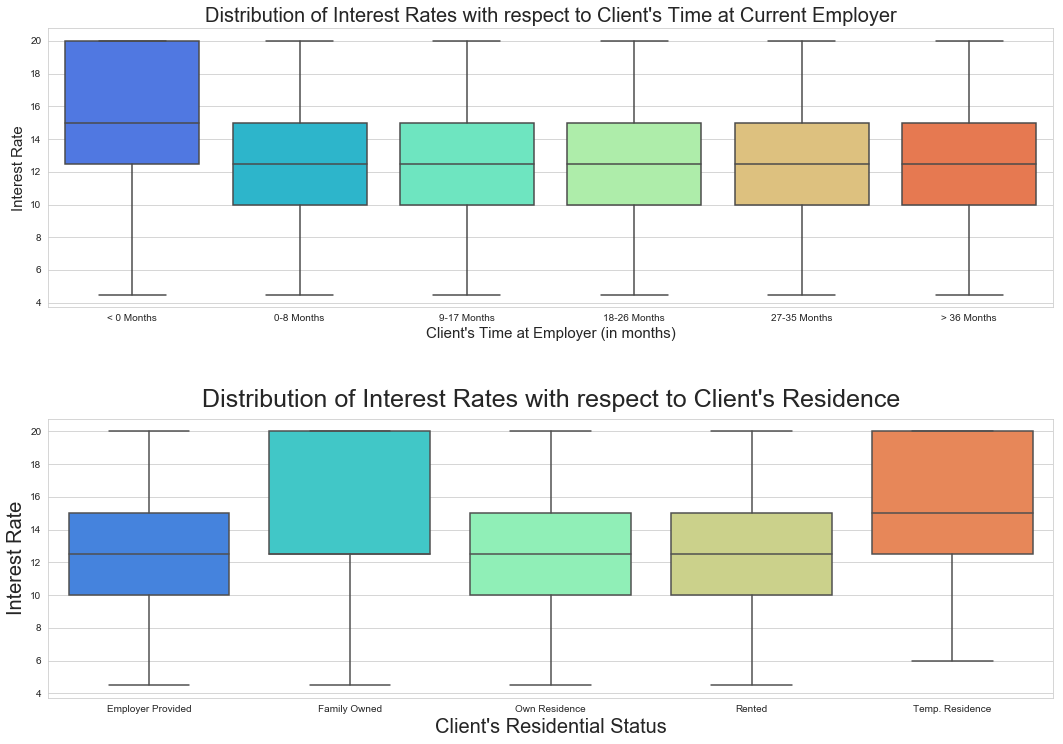

In [ ]:
# Plot the distribution of interest rates with respect to client's monthly time at current employer on a boxplot
plt.figure(figsize=(18,12))
plt.subplot(211)

sns.boxplot(x='clientTimeAtEmployer', y='interestRate', data=loans, palette='rainbow',
            order=['< 0 Months', '0-8 Months', '9-17 Months', '18-26 Months', '27-35 Months', '> 36 Months']);

plt.xlabel('Client\'s Time at Employer (in months)', fontsize=15)
plt.ylabel('Interest Rate',fontsize=15)
plt.title('Distribution of Interest Rates with respect to Client\'s Time at Current Employer', fontsize=20);

plt.subplot(212)

# Plot the distribution of interest rates with respect to client's residence on a boxplot
sns.boxplot(x='clientResidentialStauts', y='interestRate', data=loans, palette='rainbow')
plt.xlabel('Client\'s Residential Status', fontsize=20)
plt.ylabel('Interest Rate',fontsize=20)
plt.title('Distribution of Interest Rates with respect to Client\'s Residence', fontsize=25, pad=12);

plt.subplots_adjust(wspace=0.2, hspace=0.4, top=0.9)

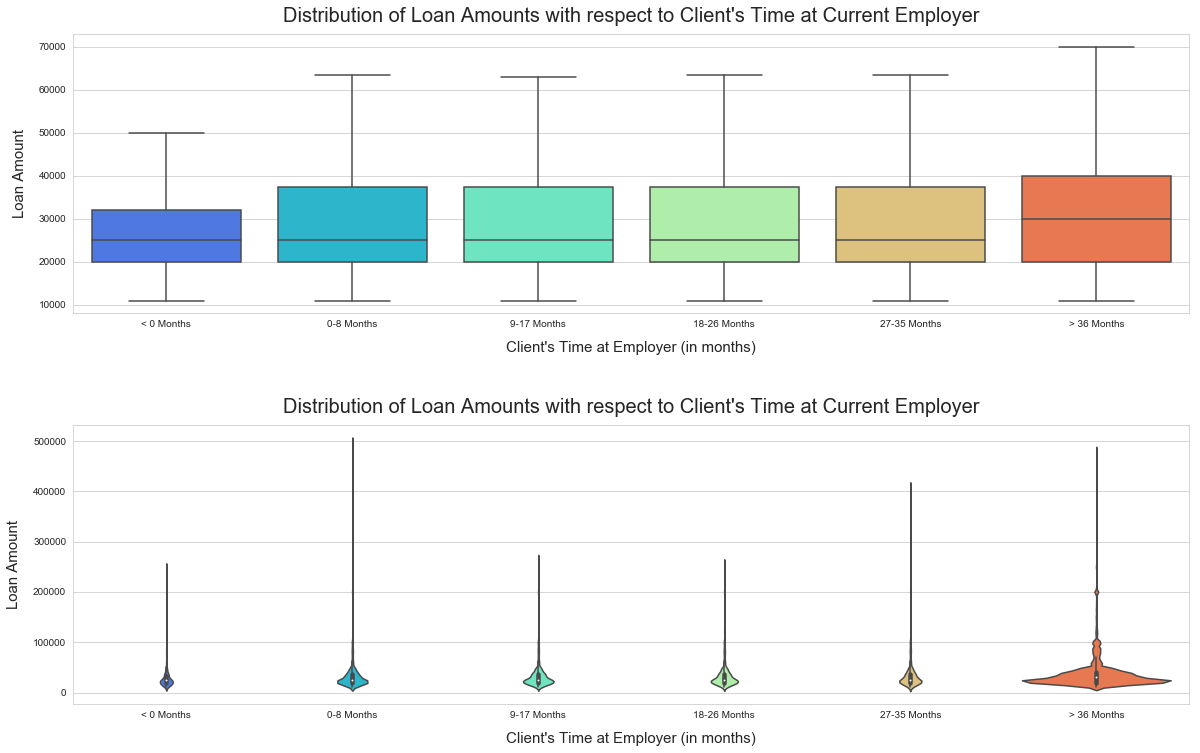

In [ ]:
# Plot the distribution of loan amounts with respect to client's monthly time at current employer on a boxplot
plt.figure(figsize=(20,12))
plt.subplot(211)

sns.boxplot(x='clientTimeAtEmployer', y='loanAmount', data=loans, palette='rainbow', showfliers=False,
               order=['< 0 Months', '0-8 Months', '9-17 Months', '18-26 Months', '27-35 Months', '> 36 Months']);

plt.xlabel('Client\'s Time at Employer (in months)', fontsize=15, labelpad = 12)
plt.ylabel('Loan Amount', fontsize=15, labelpad = 12)
plt.title('Distribution of Loan Amounts with respect to Client\'s Time at Current Employer', 
          fontsize=20, pad=12);

plt.subplot(212)
# Plot the distribution of loan amounts with respect to client's monthly time at current employer on a violinplot 
# (better reflector of the distibution's proportion)

sns.violinplot(x='clientTimeAtEmployer', y='loanAmount', data=loans, scale='count', palette='rainbow', split=True,
               order=['< 0 Months', '0-8 Months', '9-17 Months', '18-26 Months', '27-35 Months', '> 36 Months']);

plt.xlabel('Client\'s Time at Employer (in months)', fontsize=15, labelpad = 12)
plt.ylabel('Loan Amount', fontsize=15, labelpad=12)
plt.title('Distribution of Loan Amounts with respect to Client\'s Time at Current Employer', 
          fontsize=20, pad=12);

plt.subplots_adjust(wspace=0.2, hspace=0.4, top=0.9)

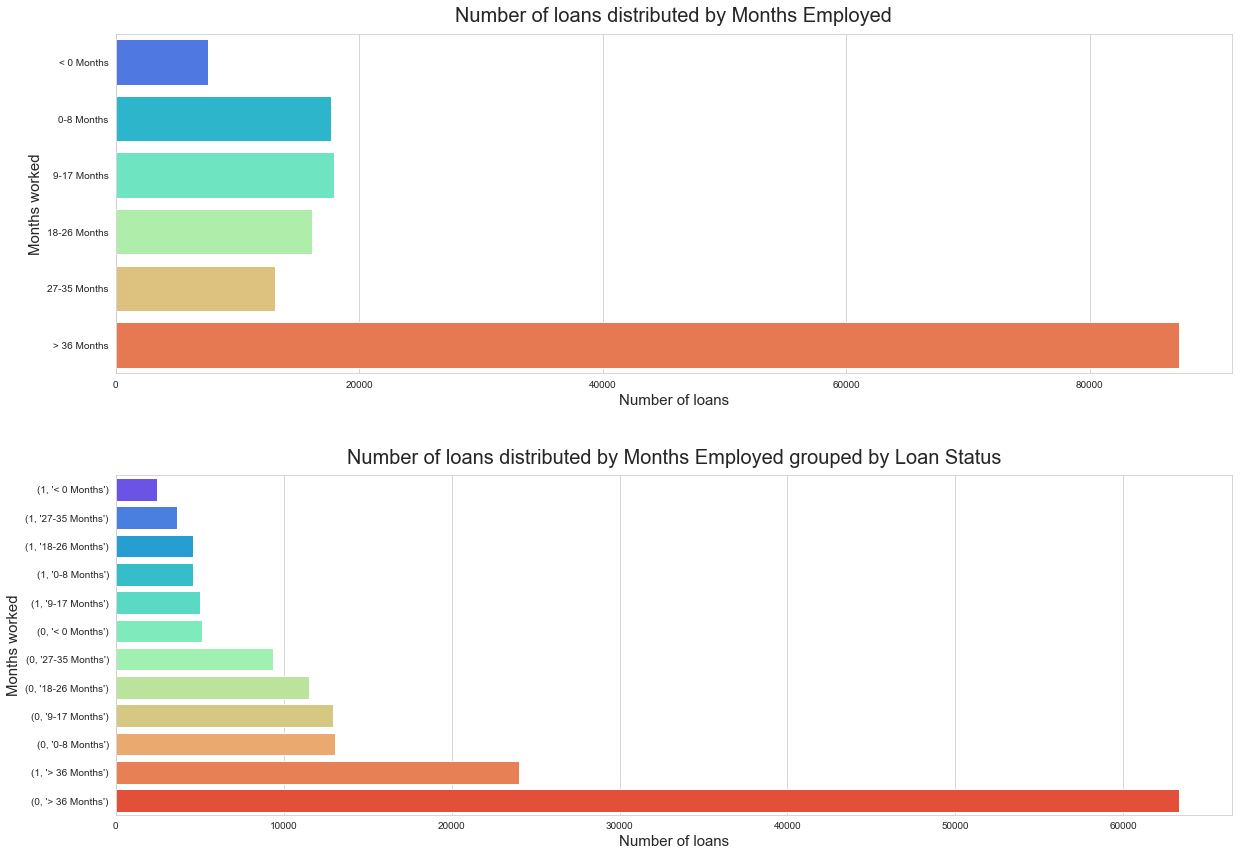

In [ ]:
# More than 75% of loans are taken out by people who have worked for 36+ Months
plt.figure(figsize=(20,14))

plt.subplot(211)

data = loans['clientTimeAtEmployer'].value_counts()
sns.barplot(x=data.values, y=data.index, palette='rainbow')
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Months worked',fontsize=15)
plt.title('Number of loans distributed by Months Employed',fontsize=20, pad=12);


plt.subplot(212)

# Counts of loans defaulted on and paid with respect to number of months worked at current empolyer
data = loans['clientTimeAtEmployer'].groupby(loans['loanDefault']).value_counts().sort_values()
sns.barplot(x=data.values, y=data.index, palette='rainbow')
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Months worked',fontsize=15)
plt.title('Number of loans distributed by Months Employed grouped by Loan Status',fontsize=20, pad=12);

plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.9)

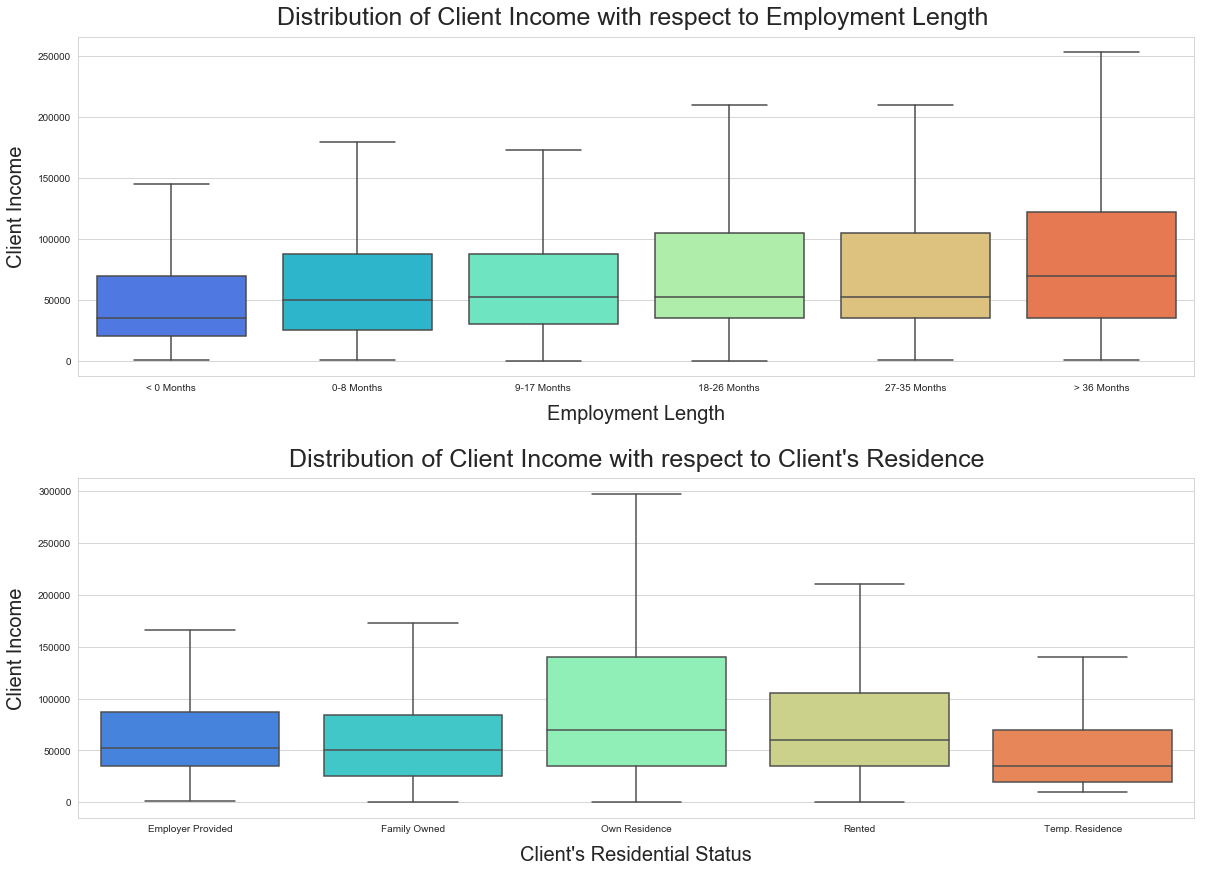

In [ ]:
# Clients who have worked for longer earn more
plt.figure(figsize=(20,14))

plt.subplot(211)

# Plot the distribution of client income with respect to client's time at current employer on a boxplot
cols = ['< 0 Months', '0-8 Months', '9-17 Months', '18-26 Months', '27-35 Months', '> 36 Months']
sns.boxplot(x='clientTimeAtEmployer', y='clientIncome', data= loans, order=cols, showfliers=False, palette='rainbow')
plt.xlabel('Employment Length', fontsize=20, labelpad=12)
plt.ylabel('Client Income', fontsize=20, labelpad=12)
plt.title('Distribution of Client Income with respect to Employment Length ', fontsize=25, pad=12);

plt.subplot(212)

# Plot the distribution of client income with respect to client's residence on a boxplot
sns.boxplot(x='clientResidentialStauts', y='clientIncome', data=loans, palette='rainbow', showfliers=False)
plt.xlabel('Client\'s Residential Status', fontsize=20, labelpad=12)
plt.ylabel('Client Income',fontsize=20, labelpad=12)
plt.title('Distribution of Client Income with respect to Client\'s Residence', fontsize=25, pad=12);
# Clients who have their own residence earn more on the average

plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.9)

### 2.4 Handle missing values in the `clientNumberPhoneContacts` column
- **`Fill Nans with mean value of clientNumberPhoneContacts grouped by age of client`**
- **Logic behind it**: Plotting **clientNumberPhoneContacts** after grouping by **clientAge** revealed a subtle trend with the two variables; the **mean** of **`clientNumberPhoneContacts`** tends to mostly **increase** gradually with the **age** of the client, save for a few exceptions. It makes more sense to fill the missing values this way compared to backward or forward filling.

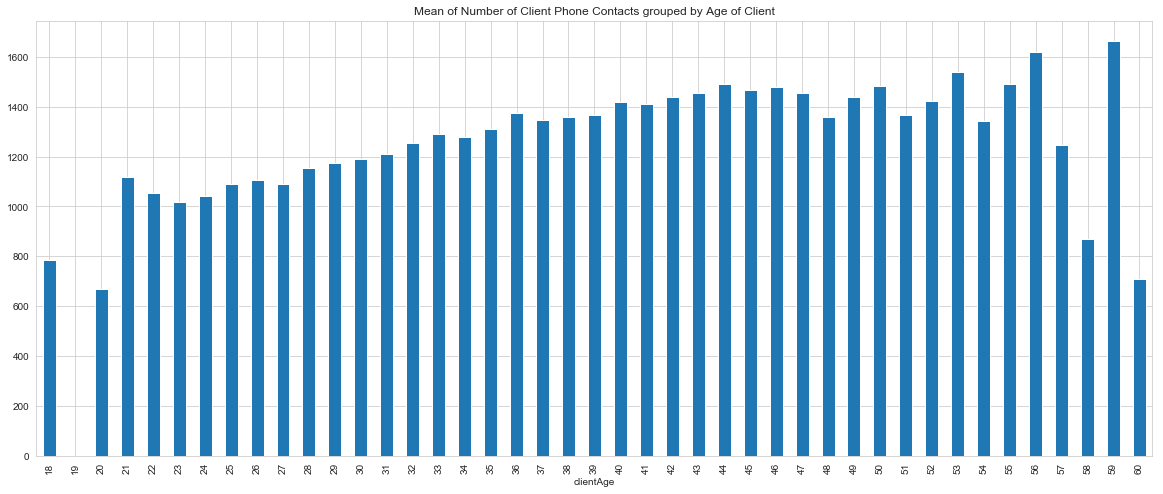

In [ ]:
plt.figure(figsize=(20,8))
loans['clientNumberPhoneContacts'].groupby(loans['clientAge']).mean().plot(kind='bar',
                    title= 'Mean of Number of Client Phone Contacts grouped by Age of Client');

In [ ]:
# Group by clientAge and transform the Nans in clientAvgCallsPerDay to the mean of the groupby
loans['clientNumberPhoneContacts'] = loans['clientNumberPhoneContacts'].groupby(loans['clientAge']).transform\
                                (lambda x: x.fillna(x.mean()))

In [ ]:
# Upon inspection, one NaN still exists. Investigate this:
loans[loans['clientNumberPhoneContacts'].isna()]

,loanId,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanType,loanNumber,applicationDate,approvalDate,declinedDate,disbursementDate,payout_status,dueDate,paidAt,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,repaidDate,settleDays,firstPaymentRatio,FirstPaymentDueDate,firstPaymentDefault,loanDefault
97621,302364636300,475193243,105000.0,0,19,FEMALE,Single,other,Own Residence,LAGOS,9-17 Months,NaN,NaN,paylater,3,2018-09-09,2018-09-09,NaN,2018-09-09,SUCCESS,2018-12-08 09:07:15,2018-09-24 04:47:22 UTC,27000,12.5,90,0,1,2018-09-24 05:44:57,-15,0.0,2018-10-09 12:00:00,0,0


In [ ]:
# Fill the one remaining NaN with the mean of clientNumberPhoneContacts
loans['clientNumberPhoneContacts'] = loans['clientNumberPhoneContacts'].transform(lambda x: x.fillna(x.mean()))

### 2.5 Handle missing values in the `clientAvgCallsPerDay `column
- **`Fill Nans with the mean value of clientAvgCallsPerDay grouped by age of Client`**
- Plotting **`clientAvgCallsPerDay`** after grouping by **`clientAge`** revealed a noticeable trend with the two variables; the **mean** of **`clientAvgCallsPerDay`** **decreases** with the **age** of the client.

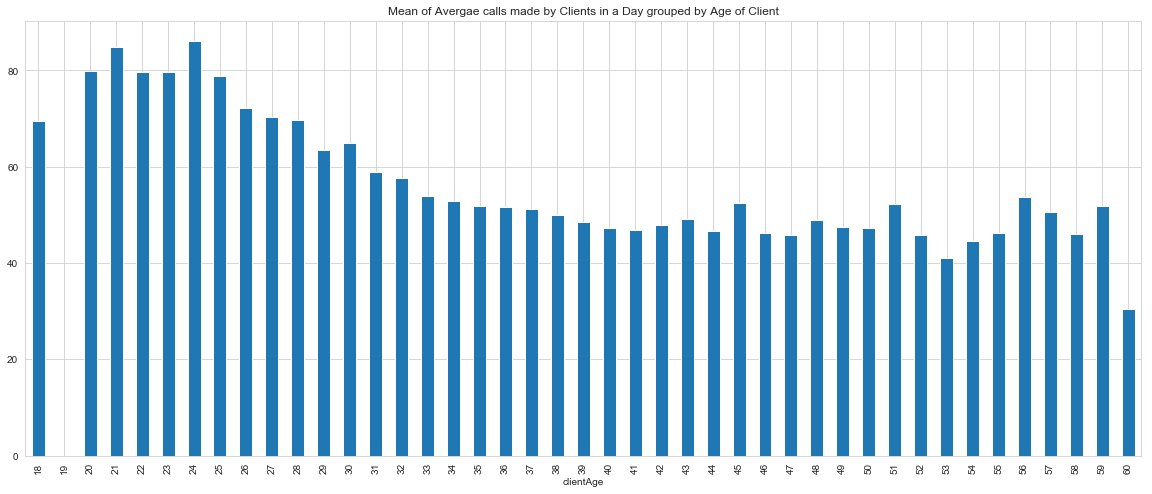

In [ ]:
plt.figure(figsize=(20,8))
loans['clientAvgCallsPerDay'].groupby(loans['clientAge']).mean().plot(kind='bar', 
            title= 'Mean of Avergae calls made by Clients in a Day grouped by Age of Client');

In [ ]:
# Group by clientAge and transform the Nans in clientAvgCallsPerDay to the mean of the groupby
loans['clientAvgCallsPerDay'] = loans['clientAvgCallsPerDay'].groupby(loans['clientAge']).transform\
                                (lambda x: x.fillna(x.mean()))

In [ ]:
# Upon inspection, one NaN still exists. Investigate this:
loans[loans['clientAvgCallsPerDay'].isna()]

,loanId,clientId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStauts,clientState,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanType,loanNumber,applicationDate,approvalDate,declinedDate,disbursementDate,payout_status,dueDate,paidAt,loanAmount,interestRate,loanTerm,max_amount_taken,max_tenor_taken,repaidDate,settleDays,firstPaymentRatio,FirstPaymentDueDate,firstPaymentDefault,loanDefault
97621,302364636300,475193243,105000.0,0,19,FEMALE,Single,other,Own Residence,LAGOS,9-17 Months,1262.055414,NaN,paylater,3,2018-09-09,2018-09-09,NaN,2018-09-09,SUCCESS,2018-12-08 09:07:15,2018-09-24 04:47:22 UTC,27000,12.5,90,0,1,2018-09-24 05:44:57,-15,0.0,2018-10-09 12:00:00,0,0


In [ ]:
# Fill the one remaining NaN with the mean of clientNumberPhoneContacts
loans['clientAvgCallsPerDay'] = loans['clientAvgCallsPerDay'].transform(lambda x: x.fillna(x.mean()))

### 2.6 Handle missing values in the `clientResidentialStauts `column
- **`Fill Nans with the mode value of clientResidentialStauts grouped by age of Client`**
- **Logic behind it**: Grouping **`clientResidentialStauts`** by **`clientAge`** revealed that **`66.67%`** 18 year olds lived in **`Family Owned`** residences, the only 19 year old lives in her **`Own Residence`**. **`40%`** of the 20 Year olds lived in **`Family Owned`** residences. For ages **`21-53`**, more client's live in **`Rented`** residences. For ages **`54-60`**, more client's lived in their **`Own Residence`**.
- The Nans in this column will be filled with the `mode` value gotten after grouping **`clientResidentialStauts`** by Age.

In [ ]:
# Group client residential status by Age and fnd the counts of the values
loans['clientResidentialStauts'].groupby(loans['clientAge']).value_counts()

clientAge  clientResidentialStauts
18         Family Owned                  2
           Rented                        1
19         Own Residence                 1
20         Family Owned                  4
           Rented                        3
           Own Residence                 2
           Employer Provided             1
21         Rented                      762
           Family Owned                598
           Own Residence               224
           Employer Provided            69
           Temp. Residence               4
22         Rented                     1404
           Family Owned               1017
           Own Residence               336
           Employer Provided           155
           Temp. Residence               9
23         Rented                     1903
           Family Owned               1330
           Own Residence               503
           Employer Provided           202
           Temp. Residence              12
24         Rented  

In [ ]:
# Group by clientAge and transform the Nans in clientResidentialStauts to the mode of the groupby
loans['clientResidentialStauts'] = loans['clientResidentialStauts'].groupby(loans['clientAge']).\
                                    transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
# Create a new feature, loan to income ratio 
loans['loan_income_ratio']= loans['loanAmount']/loans['clientIncome']

## 3. Drop Columns
- **loanId and clientId**: Values are unique to individual clients
- **clientState**: Besides LAGOS that accounts for `38.01%` of the total clients and the next 3 states `OGUN: 9.27%`, `ABUJA: 8.77%` and `OYO: 7.97%`, data from the other states are sparse.
- **loanType**: All loans are `paylater` loans
- **declinedDate**: `99.995%` Missing values
- **payout_status**: All loans have `SUCCESS` status
- **paidAt**: This feature is only known after the final payments have been made, hence it's a data leak

In [ ]:
# Drop columns
cols = ['loanId', 'clientId', 'clientState', 'loanType','declinedDate', 'payout_status','paidAt']
loans = loans.drop(cols, axis=1)

### Encode `month` Information from date columns and drop the columns

In [ ]:
# Loop through datetime columns and create new columns with the number of the month appended to the column name.
for i in dates:
    months_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'Unpaid']
    loans[i+'_Month'] = pd.Categorical(loans[i].dt.month, categories=months_order, ordered=True)

In [ ]:
# Drop the datetime columns
loans = loans.drop(dates, axis=1)

In [ ]:
# Fill Nans with 'Unpaid'; those loans are yet to be paid
loans['repaidDate_Month'] = loans['repaidDate_Month'].fillna('Unpaid')

In [ ]:
loans['repaidDate_Month'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'Unpaid'], ordered=True)

### Check Correlation of Numeric Features

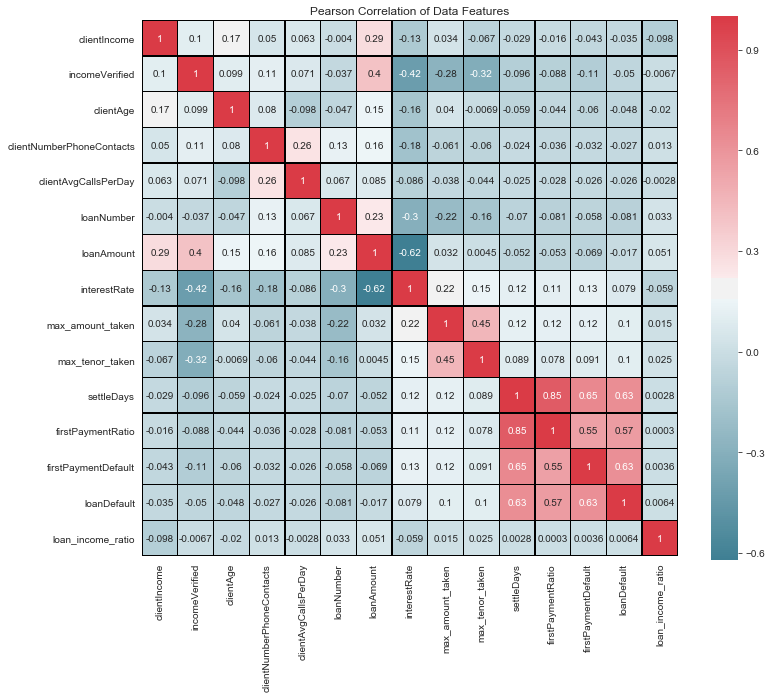

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Data Features')
sns.heatmap(loans.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap=sns.diverging_palette(220, 10, as_cmap=True), linecolor='black', annot=True);

## 4. One Hot Encode Categorical Columns

In [ ]:
# Encode categorical features using pandas get_dummies
cat_cols = ['clientGender', 'clientMaritalStatus', 'clientLoanPurpose','clientResidentialStauts','clientTimeAtEmployer',
            'loanTerm','applicationDate_Month','approvalDate_Month', 'disbursementDate_Month','dueDate_Month',
            'repaidDate_Month','FirstPaymentDueDate_Month']
ohe_cols = pd.get_dummies(loans[cat_cols], drop_first=True)
ohe_loans = pd.concat([loans, ohe_cols], axis=1)
ohe_loans = ohe_loans.drop(cat_cols, axis=1)

In [ ]:
# Copy one_hot_encoded dataframe; you'll need it to find most important features
df = ohe_loans.copy()
df_x = df.drop('loanDefault', axis=1)

In [ ]:
# Create the features and labels to fit the ExtraTreeClassifier with to determine feature importance
X = ohe_loans.drop('loanDefault', axis=1).values
y = ohe_loans['loanDefault'].values

## Use an ExtraTreeClassifier to find most important features

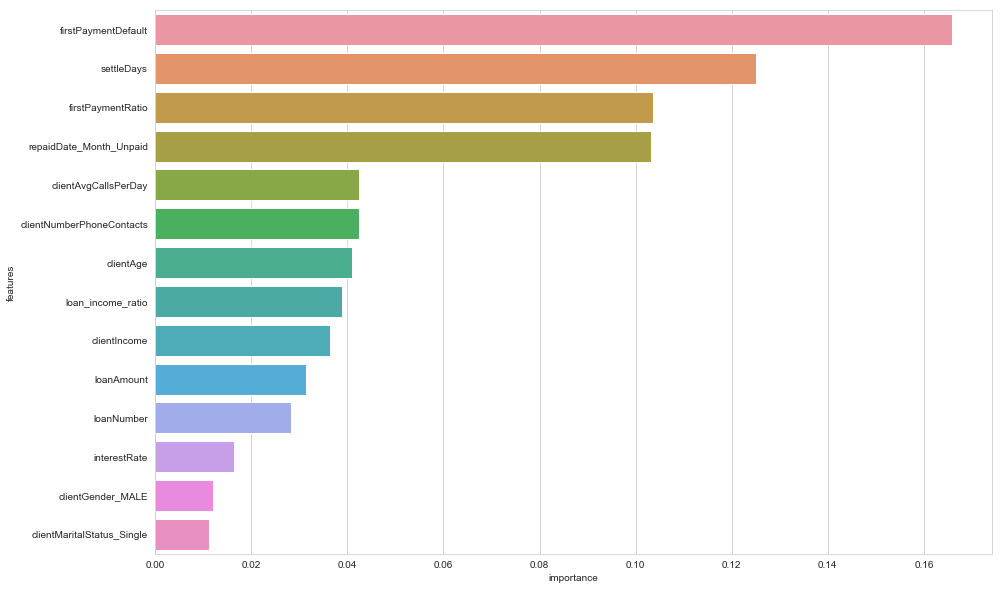

In [ ]:
# Use an ExtraTreeClassifier to find the most important features
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Initialize a random forest estimator
forest = ExtraTreesClassifier(n_estimators=50,random_state=0)

# Fit the input matrix and target values to the classifier
forest.fit(X, y)

# Retrieve the computed feature importance
importances = forest.feature_importances_

# Plot the feature importance
plot_data = pd.DataFrame({'features' : pd.Series(df_x.columns),'importance' : pd.Series(importances)})
plt.figure(figsize=(15,10))
plot_data = plot_data.sort_values('importance',ascending=False)

# Use only features with importance > 0.01
plot_data = plot_data[plot_data['importance'] > 0.01]
ax = sns.barplot(x=plot_data['importance'],y=plot_data['features'],)

## Upsample the minority class, `1` using `resample`

In [ ]:
columns = plot_data.iloc[:,0].values

In [ ]:
loans_df = pd.concat([df[columns], df[['loanDefault']]], axis=1)

In [ ]:
loans_df.loanDefault.value_counts()

0    115304
1     44292
Name: loanDefault, dtype: int64

In [ ]:
from sklearn.utils import resample
# Split the new loan dataframe according to the label classes
major_class = loans_df[loans_df['loanDefault'] == 0]
minor_class = loans_df[loans_df['loanDefault'] == 1]

n_samples = loans_df.loanDefault.value_counts().max()
# Upsample the minor class with replacement
minor_class_upsampled = resample(minor_class, replace=True, n_samples=n_samples, random_state=3005)

# Combine the major_class to upsampled minor class
resampled_data = pd.concat([major_class, minor_class_upsampled])

In [ ]:
# Confirm Upsampling
resampled_data['loanDefault'].value_counts()

1    115304
0    115304
Name: loanDefault, dtype: int64

In [ ]:
# Seperate the features from the label
X = resampled_data.drop('loanDefault', axis = 1)
y = resampled_data['loanDefault']

## Split data into train and test sets

In [ ]:
# Split the data into training and test split, using a test_size of 70%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3005)

## Scale using StandardScaler

In [ ]:
# Standardize the range of features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mercy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


## Build and Train Neural Network

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from keras.callbacks import EarlyStopping

In [ ]:
# Function that prints metrics for train and test sets
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, (clf.predict(X_train) > 0.5))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, (clf.predict(X_train) > 0.5))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, (clf.predict(X_train) > 0.5))))
        print("ROC_AUC_Score: \n {}\n".format(roc_auc_score(y_train, (clf.predict_proba(X_train)))))

    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test) > 0.5)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test) > 0.5)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test) > 0.5)))
        print("ROC_AUC_Score: \n {}\n".format(roc_auc_score(y_test, clf.predict_proba(X_test))))

In [ ]:
# Create a Densely connected neural network, initiate early stopping to prevent overfitting to training data
classifier = Sequential()
classifier.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
classifier.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier.fit(
    X_train, 
    y_train, 
    epochs=500, 
    batch_size=16, 
    callbacks=[EarlyStopping(monitor='acc')])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
161425/161425 [==============================] - 12s 71us/step - loss: 0.3966 - acc: 0.8166
Epoch 2/500
161425/161425 [==============================] - 10s 65us/step - loss: 0.3840 - acc: 0.8188
Epoch 3/500
161425/161425 [==============================] - 11s 65us/step - loss: 0.3800 - acc: 0.8191
Epoch 4/500
161425/161425 [==============================] - 10s 64us/step - loss: 0.3780 - acc: 0.8193
Epoch 5/500
161425/161425 [==============================] - 10s 65us/step - loss: 0.3763 - acc: 0.8196
Epoch 6/500
161425/161425 [==============================] - 11s 65us/step - loss: 0.3748 - acc: 0.8202
Epoch 7/500
161425/161425 [==============================] - 11s 66us/step - loss: 0.3734 - acc: 0.8203
Epoch 8/500
161425/161425 [==============================] - 11s 68us/step - loss: 0.3716 - acc: 0.8211
Epoch 9/500
161425/161425 [=====================

## Measure Baseline model's Performance after training and testing

In [ ]:
# Print training metrics
print_score(classifier, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.8230

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83     80717
           1       0.85      0.78      0.82     80708

   micro avg       0.82      0.82      0.82    161425
   macro avg       0.83      0.82      0.82    161425
weighted avg       0.83      0.82      0.82    161425


Confusion Matrix: 
 [[69713 11004]
 [17564 63144]]

ROC_AUC_Score: 
 0.9063817146165059



In [ ]:
# Print testing metrics
print_score(classifier, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8210

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83     34587
           1       0.85      0.78      0.81     34596

   micro avg       0.82      0.82      0.82     69183
   macro avg       0.82      0.82      0.82     69183
weighted avg       0.82      0.82      0.82     69183


Confusion Matrix: 
 [[29843  4744]
 [ 7639 26957]]

ROC_AUC_Score: 
 0.9037833421306319



In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from sklearn.model_selection import cross_val_score

In [ ]:
def make_classifier():
    classifier = Sequential()
    classifier.add(Dense(64, input_dim = X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(32, input_dim = X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
    classifier.add(Dropout(rate = 0.1)) 
    classifier.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return classifier

In [ ]:
K_classifier = KerasClassifier(build_fn = make_classifier, batch_size=10, nb_epoch=100)

In [ ]:
accuracies = cross_val_score(estimator = K_classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)

In [ ]:
# Compute cross validation metrics
# A better model has higher variance between the features
print("Mean: {}\n".format(accuracies.mean()))
print("Variance: {}\n".format(accuracies.var()))

Mean: 0.8179649034650893

Variance: 1.093771081530379e-05



## Parameter Tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Modify the function used to build the NN so optimal parameters can be found using GridSearchCV
def tune_make_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
    classifier.add(Dropout(rate = 0.1))
    classifier.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return classifier

In [ ]:
# Instantaite the KerasClassifier which serves as a wrapper for the network
k_classifier = KerasClassifier(build_fn = tune_make_classifier)

In [ ]:
# Parameters to loop over
params = {
    'batch_size':[16,32,64],
    'nb_epoch':[50,100],
    'optimizer':['adam','rmsprop','sgd']}

In [ ]:
# Use GridSearchCV to iterate over the following parameters: Grab a cup of Coffee cause it's going to be a while.
grid_search = GridSearchCV(estimator=k_classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=10)
grid_search = grid_search.fit(X_train, y_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/1
145282/145282 [==============================] - 12s 84us/step - loss: 0.4071 - acc: 0.8154
Epoch 1/1
145282/145282 [==============================] - 13s 92us/step - loss: 0.4053 - acc: 0.8160
Epoch 1/1
145282/145282 [==============================] - 15s 102us/step - loss: 0.4061 - acc: 0.8155
Epoch 1/1
145282/145282 [==============================] - 18s 127us/step - loss: 0.4047 - acc: 0.8166
Epoch 1/1
145282/145282 [==============================] - 12s 82us/step - loss: 0.4062 - acc: 0.8161
Epoch 1/1
145283/145283 [==============================] - 13s 87us/step - loss: 0.4053 - acc: 0.8165
Epoch 1/1
145283/145283 [==============================] - 17s 116us/step - loss: 0.4053 - acc: 0.8171
Epoch 1/1
145283/145283 [==============================] - 14s 96us/step - loss: 0.4050 - acc: 0.8170
Epoch 1/1
145283/145283 [==============================] - 14s 99u

In [ ]:
# Compute cross validation metrics
print("Best Paramters from GridSearchCV: {}\n".format(grid_search.best_params_))
print("Best Score from GridSearchCV: {}\n".format(grid_search.best_score_))

Best Paramters from GridSearchCV: {'batch_size': 16, 'nb_epoch': 100, 'optimizer': 'sgd'}

Best Score from GridSearchCV: 0.8188136905683754



## Use best parameters obtained during GridSearchCV to create NN

In [ ]:
# Create NN with Optimimal parameters 
n_classifier = Sequential()
n_classifier.add(Dense(64, input_dim = X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
n_classifier.add(Dropout(rate = 0.1))
n_classifier.add(Dense(32, input_dim = X_train.shape[1], kernel_initializer = 'uniform', activation='relu'))
n_classifier.add(Dropout(rate = 0.1)) 
n_classifier.add(Dense(1, kernel_initializer = 'uniform', activation='sigmoid'))
n_classifier.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

n_classifier.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=16, 
    callbacks=[EarlyStopping(monitor='acc')])

Epoch 1/100
161425/161425 [==============================] - 69s 426us/step - loss: 0.4755 - acc: 0.7787
Epoch 2/100
161425/161425 [==============================] - 57s 353us/step - loss: 0.4024 - acc: 0.8173
Epoch 3/100
161425/161425 [==============================] - 59s 365us/step - loss: 0.3984 - acc: 0.8177
Epoch 4/100
161425/161425 [==============================] - 49s 303us/step - loss: 0.3950 - acc: 0.8168


## Print Model Performance

In [ ]:
# Print training metrics
print_score(n_classifier, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.8185

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     80717
           1       0.87      0.74      0.80     80708

   micro avg       0.82      0.82      0.82    161425
   macro avg       0.83      0.82      0.82    161425
weighted avg       0.83      0.82      0.82    161425


Confusion Matrix: 
 [[72125  8592]
 [20712 59996]]

ROC_AUC_Score: 
 0.890862343905924



In [ ]:
# Print testing metrics
print_score(n_classifier, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8177

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     34587
           1       0.87      0.74      0.80     34596

   micro avg       0.82      0.82      0.82     69183
   macro avg       0.82      0.82      0.82     69183
weighted avg       0.82      0.82      0.82     69183


Confusion Matrix: 
 [[30850  3737]
 [ 8873 25723]]

ROC_AUC_Score: 
 0.8900947550452657



# Model Comparisons

1. **Random Forest Classifier**: A couple of posts commented about how Random forests not handling class imbalance too well, to test this out I built a separate Random Forest classifier where the minority class was balanced using the **SMOTE** technique. This can be found here: [SMOTE Balanced Random Forest Classifier](https://colab.research.google.com/drive/12EgmfQq9hH8YlQnnaCWFOoT4jpfotgVY). The balanced model has a better accuracy during training and testing,  the imbalanced RFC had better precision during testing. The testing precision of the imbalanced RFC twhich imporves, the other metrics are almost at par. The SMOTE balanced RFC was more sensitive towards classifying loan defaulters as defaulters (0.65 compared to 0.60 in the imbalanced RFC). Due to this, I'll be comparing the Neural Network to the SMOTE Balanced Random Forest Classifier.

## Random Forest Classifier without Balancing the classes:
### Model Performance before parameter tuning: 
```
Train Result:
accuracy score: 0.9852
Classification Report: 
               precision    recall  f1-score   support
           0       0.98      1.00      0.99     86577
           1       1.00      0.95      0.97     33120

   micro avg       0.99      0.99      0.99    119697
   macro avg       0.99      0.97      0.98    119697
weighted avg       0.99      0.99      0.99    119697

Confusion Matrix: 
 [[86542    35]
 [ 1741 31379]]

ROC_AUC_Score: 
 0.9997063485666524

Average Accuracy: 	 0.8683
Accuracy SD: 		 0.0033
```

```
Test Result:
accuracy score: 0.8638
Classification Report: 
               precision    recall  f1-score   support
           0       0.86      0.97      0.91     28727
           1       0.88      0.60      0.71     11172

   micro avg       0.86      0.86      0.86     39899
   macro avg       0.87      0.78      0.81     39899
weighted avg       0.87      0.86      0.85     39899

Confusion Matrix: 
 [[27801   926]
 [ 4508  6664]]

ROC_AUC_Score: 
 0.8696513664176255
```

## Model Performance after parameter tuning:
```
Train Result:
accuracy score: 0.9852
Classification Report: 
               precision    recall  f1-score   support
           0       0.98      1.00      0.99     86577
           1       1.00      0.95      0.97     33120

   micro avg       0.99      0.99      0.99    119697
   macro avg       0.99      0.97      0.98    119697
weighted avg       0.99      0.99      0.99    119697

Confusion Matrix: 
 [[86542    35]
 [ 1741 31379]]

ROC_AUC_Score: 
 0.9997063485666524

Average Accuracy: 	 0.8763
Accuracy SD: 		 0.0035
```

```
Test Result:
accuracy score: 0.8638
Classification Report: 
               precision    recall  f1-score   support
           0       0.86      0.97      0.91     28727
           1       0.88      0.60      0.71     11172

   micro avg       0.86      0.86      0.86     39899
   macro avg       0.87      0.78      0.81     39899
weighted avg       0.87      0.86      0.85     39899

Confusion Matrix: 
 [[27801   926]
 [ 4508  6664]]

ROC_AUC_Score: 
 0.8696513664176255
```

## **Random Forest Classifier after Balancing the classes using SMOTE**:
### Model Performance before parameter tuning: 


```
Train Result:
accuracy score: 0.9926
Classification Report: 
               precision    recall  f1-score   support
           0       0.99      1.00      0.99     86577
           1       1.00      0.99      0.99     86577

   micro avg       0.99      0.99      0.99    173154
   macro avg       0.99      0.99      0.99    173154
weighted avg       0.99      0.99      0.99    173154

Confusion Matrix: 
 [[86466   111]
 [ 1168 85409]]

ROC_AUC_Score: 
 0.9998702660903609

Average Accuracy: 	 0.8922
Accuracy SD: 		 0.0527
```

```
Test Result:
accuracy score: 0.8578
Classification Report: 
               precision    recall  f1-score   support
           0       0.87      0.94      0.90     28727
           1       0.81      0.65      0.72     11172

   micro avg       0.86      0.86      0.86     39899
   macro avg       0.84      0.79      0.81     39899
weighted avg       0.85      0.86      0.85     39899

Confusion Matrix: 
 [[26988  1739]
 [ 3935  7237]]

ROC_AUC_Score: 
 0.8749561348357939
```

## Model Performance after parameter tuning:
```
Train Result:
accuracy score: 0.9926
Classification Report: 
               precision    recall  f1-score   support
           0       0.99      1.00      0.99     86577
           1       1.00      0.99      0.99     86577

   micro avg       0.99      0.99      0.99    173154
   macro avg       0.99      0.99      0.99    173154
weighted avg       0.99      0.99      0.99    173154

Confusion Matrix: 
 [[86466   111]
 [ 1168 85409]]

ROC_AUC_Score: 
 0.9998702660903609

Average Accuracy: 	 0.9048
Accuracy SD: 		 0.0547
```

```
Test Result:
accuracy score: 0.8578
Classification Report: 
               precision    recall  f1-score   support
           0       0.87      0.94      0.90     28727
           1       0.81      0.65      0.72     11172

   micro avg       0.86      0.86      0.86     39899
   macro avg       0.84      0.79      0.81     39899
weighted avg       0.85      0.86      0.85     39899

Confusion Matrix: 
 [[26988  1739]
 [ 3935  7237]]

ROC_AUC_Score: 
 0.8749561348357939
```

##  2. Neural Network: 
The SMOTE balanced RFC makes more accurate predictions compared with the neural network. The neural network out performs the RFC in terms of its sensitivity towards predicting loan defaulters. This is where it truly does better than the RFC. Also, the Random Forest Classifier might not generalize well to new data as it is most likely overfitting during training.
# Verdict: Due to this, I'd pick the Neural Network over the random forest classifier.
### Model Performance before parameter tuning:


```
Train Result:

accuracy score: 0.8230

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83     80717
           1       0.85      0.78      0.82     80708

   micro avg       0.82      0.82      0.82    161425
   macro avg       0.83      0.82      0.82    161425
weighted avg       0.83      0.82      0.82    161425


Confusion Matrix: 
 [[69713 11004]
 [17564 63144]]

ROC_AUC_Score: 
 0.9063817146165059
```



```
Test Result:

accuracy score: 0.8210

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83     34587
           1       0.85      0.78      0.81     34596

   micro avg       0.82      0.82      0.82     69183
   macro avg       0.82      0.82      0.82     69183
weighted avg       0.82      0.82      0.82     69183


Confusion Matrix: 
 [[29843  4744]
 [ 7639 26957]]

ROC_AUC_Score: 
 0.9037833421306319
```

## Model Performance after parameter tuning:


```
Train Result:

accuracy score: 0.8185

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     80717
           1       0.87      0.74      0.80     80708

   micro avg       0.82      0.82      0.82    161425
   macro avg       0.83      0.82      0.82    161425
weighted avg       0.83      0.82      0.82    161425


Confusion Matrix: 
 [[72125  8592]
 [20712 59996]]

ROC_AUC_Score: 
 0.890862343905924
```




```
Test Result:

accuracy score: 0.8177

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     34587
           1       0.87      0.74      0.80     34596

   micro avg       0.82      0.82      0.82     69183
   macro avg       0.82      0.82      0.82     69183
weighted avg       0.82      0.82      0.82     69183


Confusion Matrix: 
 [[30850  3737]
 [ 8873 25723]]

ROC_AUC_Score: 
 0.8900947550452657
```



### My models aimed to reduce the amount lost by the company to defaulters whilst still giving out loans to individuals most likely to pay back.

In [ ]:
rate = (loans[loans.loanDefault==1]['loanAmount'].sum()/loans['loanAmount'].sum())*100
total = loans.loanAmount.sum()
print('My decisions were influenced by trying to reduce the rate of {}% which was the percentage of\n the total loan amounts disbursed to the defaulting clients in 2018 out of ₦{:,.2f}.'.format(rate.round(2), total))

My decisions were influenced by trying to reduce the rate of 27.14% which was the percentage of
 the total loan amounts disbursed to the defaulting clients in 2018 out of ₦5,637,598,500.00.
